# ChordCutter Bot


## Dataset

[Music Bench](https://huggingface.co/datasets/amaai-lab/MusicBench)


In [37]:
# Libraries
import os
import torch
import requests
import tarfile
import librosa
from io import BytesIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from datasets import load_dataset

In [2]:
ds = load_dataset("amaai-lab/MusicBench")
ds

DatasetDict({
    train: Dataset({
        features: ['dataset', 'location', 'main_caption', 'alt_caption', 'prompt_aug', 'prompt_ch', 'prompt_bt', 'prompt_bpm', 'prompt_key', 'beats', 'bpm', 'chords', 'chords_time', 'key', 'keyprob', 'is_audioset_eval_mcaps'],
        num_rows: 52768
    })
    test: Dataset({
        features: ['dataset', 'location', 'main_caption', 'alt_caption', 'prompt_aug', 'prompt_ch', 'prompt_bt', 'prompt_bpm', 'prompt_key', 'beats', 'bpm', 'chords', 'chords_time', 'key', 'keyprob', 'is_audioset_eval_mcaps'],
        num_rows: 800
    })
})

In [3]:
train_df = ds['train'].to_pandas()
test_df = ds['test'].to_pandas()

train_df
# test_df

dataset                     location  \
0      MusicBench  data_aug2/-0SdAVK79lg_1.wav   
1      MusicBench  data_aug2/-0SdAVK79lg_2.wav   
2      MusicBench  data_aug2/-0SdAVK79lg_3.wav   
3      MusicBench  data_aug2/-0SdAVK79lg_4.wav   
4      MusicBench  data_aug2/-0SdAVK79lg_5.wav   
...           ...                          ...   
52763  MusicBench         data/zir3uL14ijM.wav   
52764  MusicBench         data/zjZV0tvur2I.wav   
52765  MusicBench         data/zjsWFvUkh7M.wav   
52766  MusicBench         data/zqbHYVH6Wqo.wav   
52767  MusicBench         data/zwfo7wnXdjs.wav   

                                            main_caption  \
0      This mellow instrumental track showcases a dom...   
1      This relaxing song is perfect for a coffee sho...   
2      This laid-back instrumental track is perfect f...   
3      This is a relaxing song that features an elect...   
4      This relaxing song is perfect for a coffee sho...   
...                                                  ...   
52763  This mellow tune is led by a passionate male v...   
52764  This song, in the key of G minor and with a te...   
52765  This Pop Rock song is led by a lively male voc...   
52766  This devotional and spirited instrumental song...   
52767  This emotional instrumental song is played at ...   

                                             alt_caption prompt_aug  \
0      This song features an electric guitar as the m...              
1      This song features an electric guitar as the m...              
2      This song features an electric guitar as the m...              
3      This song features an electric guitar as the m...              
4      This song features an electric guitar as the m...              
...                                                  ...        ...   
52763  The low quality recording features a passionat...              
52764  The low quality recording features a widely sp...              
52765  A male vocalist sings this energetic song. The...              
52766  The song is an instrumental. The tempo is medi...              
52767  The song is an instrumental. The song is mediu...              

                                               prompt_ch  \
0               The chord progression in this song is E.   
1               The chord progression in this song is E.   
2               The chord progression in this song is E.   
3               The chord progression in this song is E.   
4                              The chord sequence is C#.   
...                                                  ...   
52763  The chord progression in this song is E, F#m7,...   
52764                         The chord sequence is Ab7.   
52765                 The chord sequence is D, Gm, Daug.   
52766                           The chord sequence is F.   
52767  The chord progression in this song is Abm, F#m...   

                        prompt_bt  \
0           The beat counts to 4.   
1                  The beat is 4.   
2           The beat counts to 4.   
3                  The beat is 4.   
4      The time signature is 4/4.   
...                           ...   
52763              The beat is 3.   
52764       The beat counts to 2.   
52765              The beat is 3.   
52766              The beat is 2.   
52767              The beat is 2.   

                                              prompt_bpm  \
0                                      The bpm is 112.0.   
1              The song is played at the pace of Vivace.   
2                                      The bpm is 151.0.   
3              The song is played at the pace of Vivace.   
4              This song goes at 130.0 beats per minute.   
...                                                  ...   
52763                                   The bpm is 92.0.   
52764  The tempo of this song is 127.0 beats per minute.   
52765          This song goes at 110.0 beats per minute.   
52766                     This song is played in Presto.   
52767    

In [39]:
def open_audio_file(location='', num=-1):
    ''' 
    Gets the tar file online without reading everything into memory. Iterates through response one file at a time.
    Only considers files (and currently .wav files). Can be used to get a specific file, though this is achieved
    by iterating over every item in the decompressed tar file. Can also be used to get a specific number of files.

    Input
    - location: the filepath (as provided by the "Location" column in the dataset) to retrieve (note: current implementation is very inefficient). Default is the empty string, which will output all files
    - num: the number of files to retrieve, from the beginning. Default is -1, which will output all the files

    Output
    - None
    '''
    url = 'https://huggingface.co/datasets/amaai-lab/MusicBench/resolve/main/MusicBench.tar.gz'
    response = requests.get(url, stream=True)
    print("response received!")
    print(response, '\n')
    retrieved_count = 0
    
    if response.status_code == 200:
        # open tar file as a stream
        with tarfile.open(fileobj=response.raw, mode='r|gz') as tar:
            print("opened tar file!")

            for member in tar:
                # only care about files
                # if location is given, only get that file; otherwise get all files
                if member.isfile() and (member.name == f"datashare/{location}" or not location):
                    file = tar.extractfile(member)
                    print("Type:", type(file))
                    print("File:", file)
                    print(f"File name: {member.name}")

                    file = tar.extractfile(member)
                    print("Extracted file:", file, '\n')

                    # read this file into memory
                    file_bytes = BytesIO(file.read())

                    # only get audio files
                    if member.name.endswith('.wav'):
                        audio_data, sr = librosa.load(file_bytes, sr=None)

                        # metadata
                        print("-----METADATA-----")
                        print(f"Audio length: {len(audio_data)} samples, Sample Rate: {sr}")
                        print(type(audio_data), audio_data.shape)
                        print("audio_data element:", audio_data[0])

                        # sound amplitude
                        plt.plot(audio_data)
                        plt.show()

                        # Mel-frequency cepstral coefficients
                        mfccs = librosa.feature.mfcc(y=audio_data, sr=sr, n_mfcc=13)
                        print("MFCCs:", mfccs.shape)

                        # chroma feature extraction
                        chroma = librosa.feature.chroma_stft(y=audio_data, sr=sr)
                        plt.imshow(chroma, aspect='auto', origin='lower')
                        plt.title('Chroma Feature')
                        plt.xlabel('Frame')
                        plt.ylabel('Pitch Class')
                        plt.show()

                    file.close()
                    if location:  # stop after finding requested file
                        break
                    else:
                        retrieved_count += 1
                        if retrieved_count == num:
                            break
    else:
        print(f"Failed to download the file: {response.status_code}")

response received!
<Response [200]> 

opened tar file!
Type: <class 'tarfile.ExFileObject'>
File: <ExFileObject name=''>
File name: datashare/data_aug2/u3yOMK8SuRI_1.wav
Extracted file: <ExFileObject name=''> 

-----METADATA-----
Audio length: 160000 samples, Sample Rate: 16000
<class 'numpy.ndarray'> (160000,)
audio_data element: 0.0


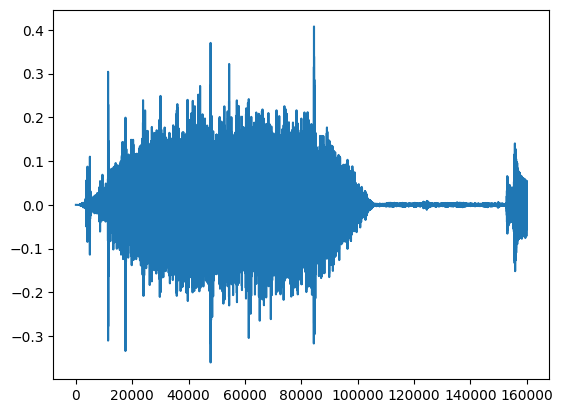

MFCCs: (13, 313)


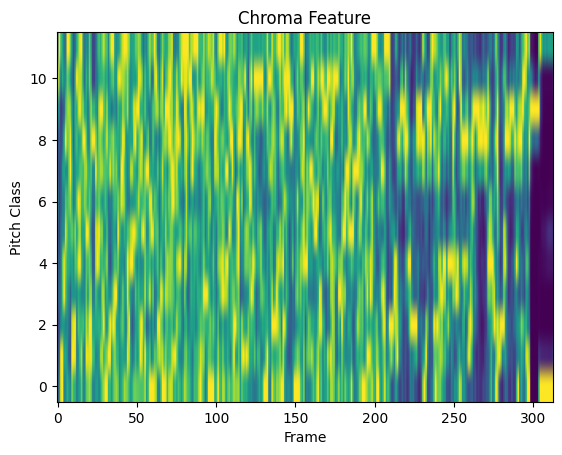

Type: <class 'tarfile.ExFileObject'>
File: <ExFileObject name=''>
File name: datashare/data_aug2/4a1a-lmDVaY_11.wav
Extracted file: <ExFileObject name=''> 

-----METADATA-----
Audio length: 160000 samples, Sample Rate: 16000
<class 'numpy.ndarray'> (160000,)
audio_data element: 0.0024597168


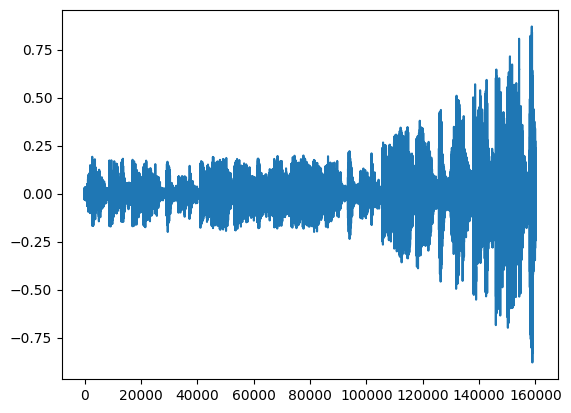

MFCCs: (13, 313)


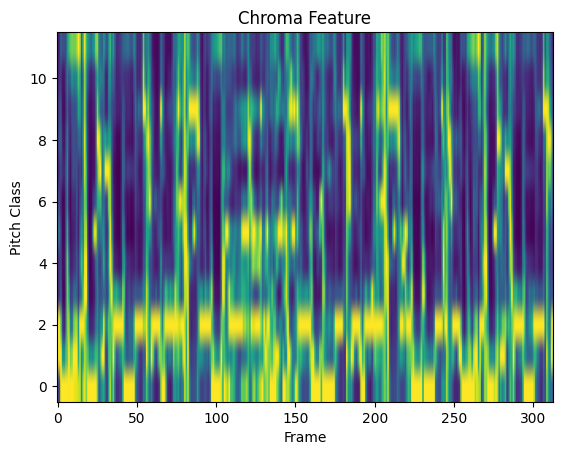

In [ ]:
# get specific number of audio files
open_audio_file(num=2)

response received!
<Response [200]> 

opened tar file!
Type: <class 'tarfile.ExFileObject'>
File: <ExFileObject name=''>
File name: datashare/data_aug2/u3yOMK8SuRI_1.wav
Extracted file: <ExFileObject name=''> 

-----METADATA-----
Audio length: 160000 samples, Sample Rate: 16000
<class 'numpy.ndarray'> (160000,)
audio_data element: 0.0


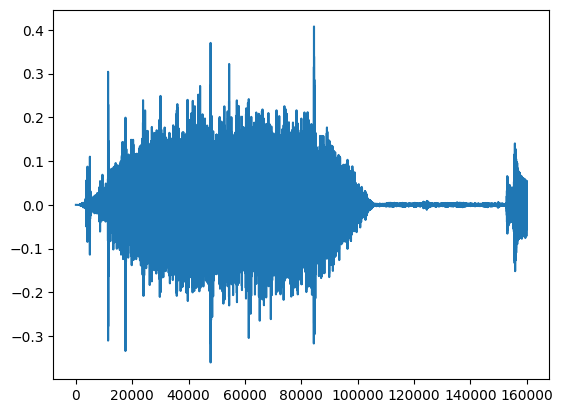

MFCCs: (13, 313)


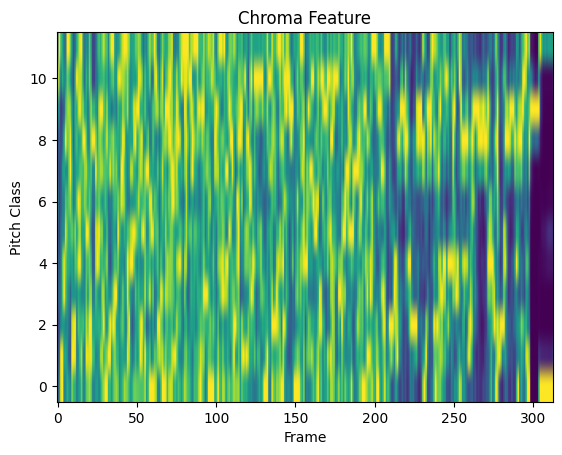

In [ ]:
# get audio file by location (see table)
open_audio_file("data_aug2/u3yOMK8SuRI_1.wav")

response received!
<Response [200]> 

opened tar file!
Type: <class 'tarfile.ExFileObject'>
File: <ExFileObject name=''>
File name: datashare/data_aug2/u3yOMK8SuRI_1.wav
Extracted file: <ExFileObject name=''> 

-----METADATA-----
Audio length: 160000 samples, Sample Rate: 16000
<class 'numpy.ndarray'> (160000,)
audio_data element: 0.0


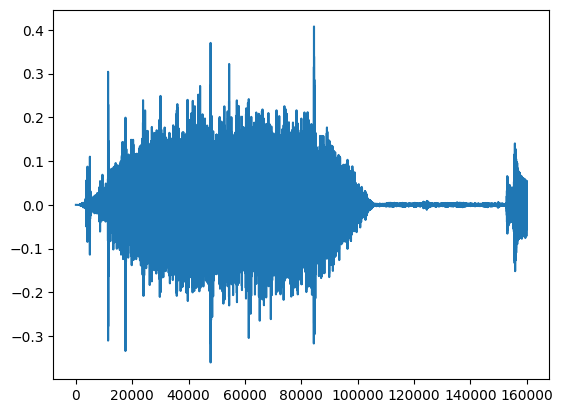

MFCCs: (13, 313)


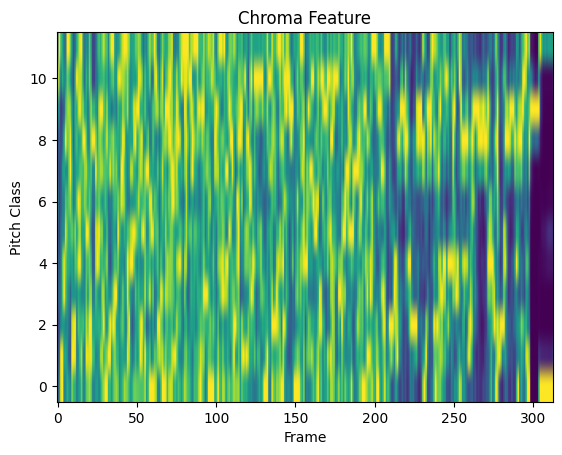

Type: <class 'tarfile.ExFileObject'>
File: <ExFileObject name=''>
File name: datashare/data_aug2/4a1a-lmDVaY_11.wav
Extracted file: <ExFileObject name=''> 

-----METADATA-----
Audio length: 160000 samples, Sample Rate: 16000
<class 'numpy.ndarray'> (160000,)
audio_data element: 0.0024597168


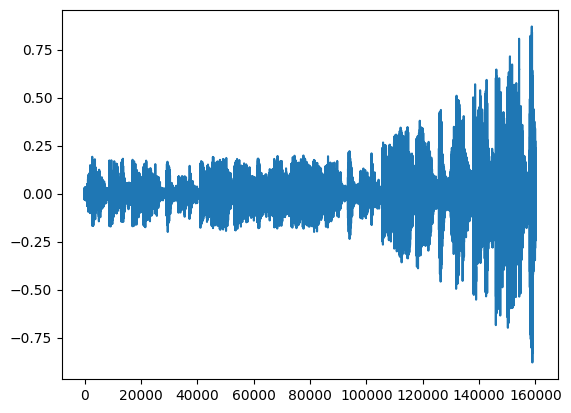

MFCCs: (13, 313)


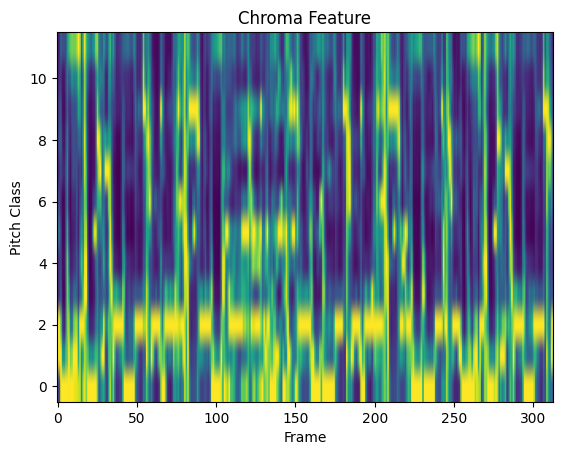

Type: <class 'tarfile.ExFileObject'>
File: <ExFileObject name=''>
File name: datashare/data_aug2/rE7S4nLrThs_5.wav
Extracted file: <ExFileObject name=''> 

-----METADATA-----
Audio length: 160000 samples, Sample Rate: 16000
<class 'numpy.ndarray'> (160000,)
audio_data element: -0.031066895


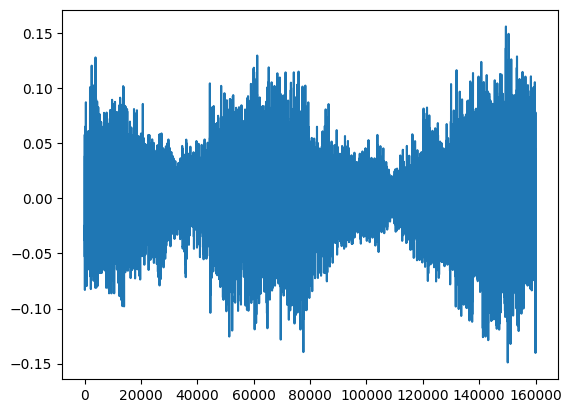

MFCCs: (13, 313)


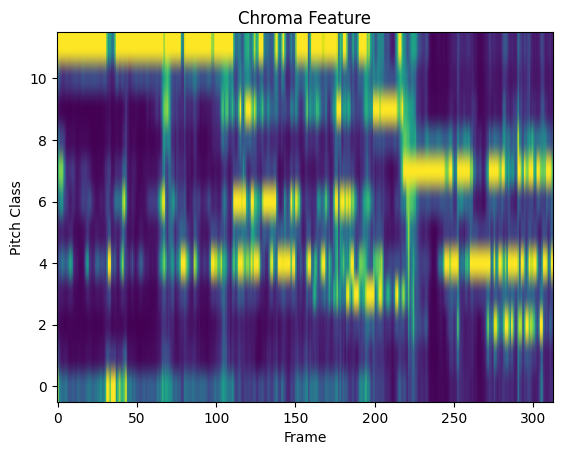

Type: <class 'tarfile.ExFileObject'>
File: <ExFileObject name=''>
File name: datashare/data_aug2/RneRJ5ZnHlE_2.wav
Extracted file: <ExFileObject name=''> 

-----METADATA-----
Audio length: 160000 samples, Sample Rate: 16000
<class 'numpy.ndarray'> (160000,)
audio_data element: 0.06460571


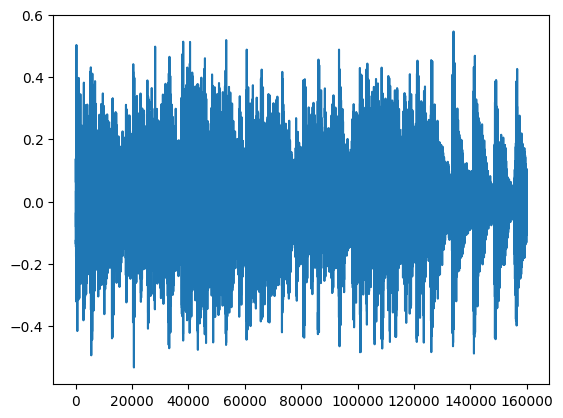

MFCCs: (13, 313)


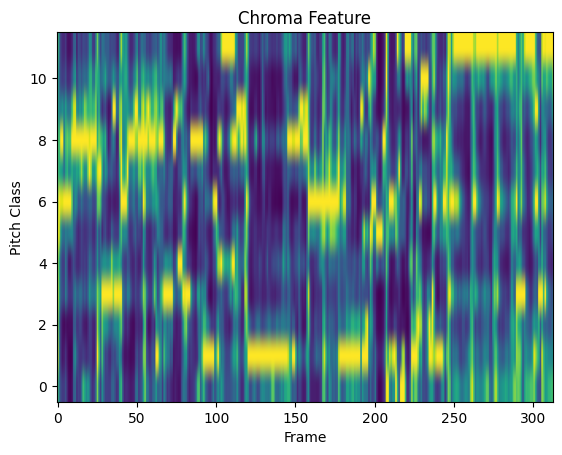

Type: <class 'tarfile.ExFileObject'>
File: <ExFileObject name=''>
File name: datashare/data_aug2/Wu-Oh9OJIlI_9.wav
Extracted file: <ExFileObject name=''> 

-----METADATA-----
Audio length: 160000 samples, Sample Rate: 16000
<class 'numpy.ndarray'> (160000,)
audio_data element: 0.24996948


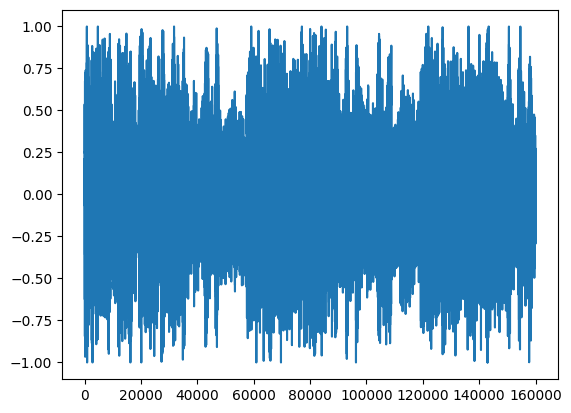

MFCCs: (13, 313)


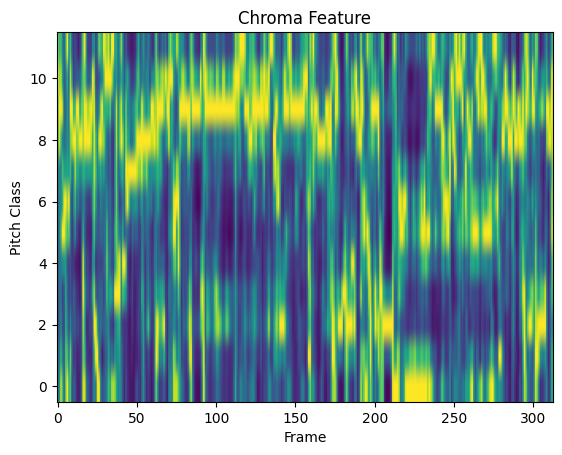

Type: <class 'tarfile.ExFileObject'>
File: <ExFileObject name=''>
File name: datashare/data_aug2/z8Wjdss5uMg_1.wav
Extracted file: <ExFileObject name=''> 

-----METADATA-----
Audio length: 138022 samples, Sample Rate: 16000
<class 'numpy.ndarray'> (138022,)
audio_data element: -6.1035156e-05


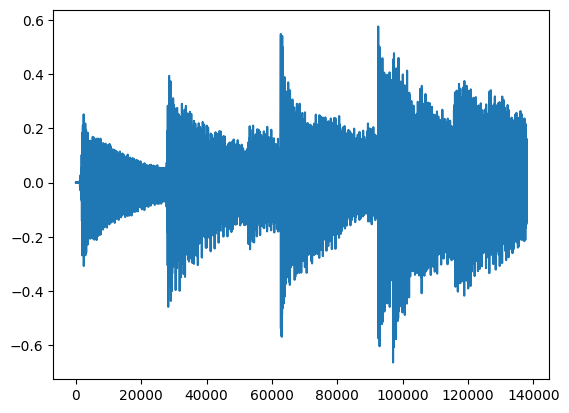

MFCCs: (13, 270)


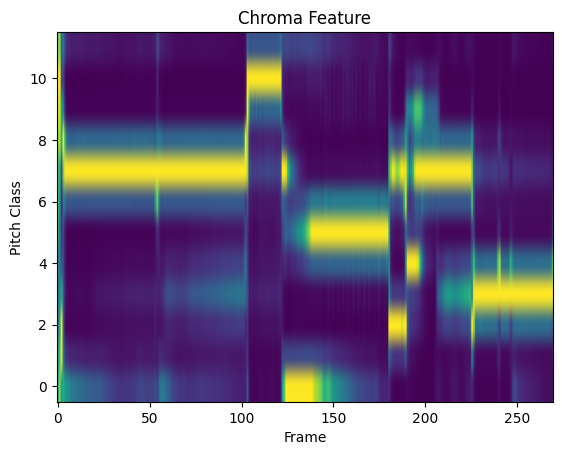

Type: <class 'tarfile.ExFileObject'>
File: <ExFileObject name=''>
File name: datashare/data_aug2/IlUcHzBzZvg_10.wav
Extracted file: <ExFileObject name=''> 

-----METADATA-----
Audio length: 160000 samples, Sample Rate: 16000
<class 'numpy.ndarray'> (160000,)
audio_data element: 0.08459473


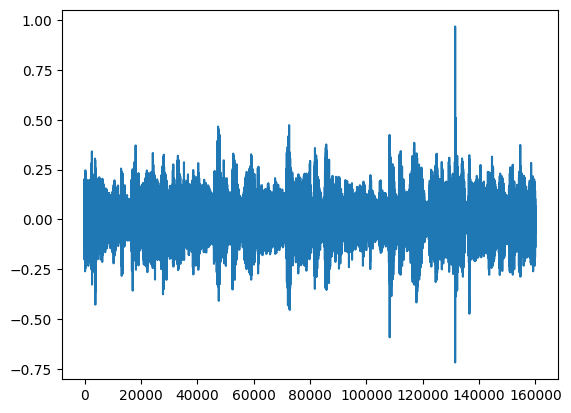

MFCCs: (13, 313)


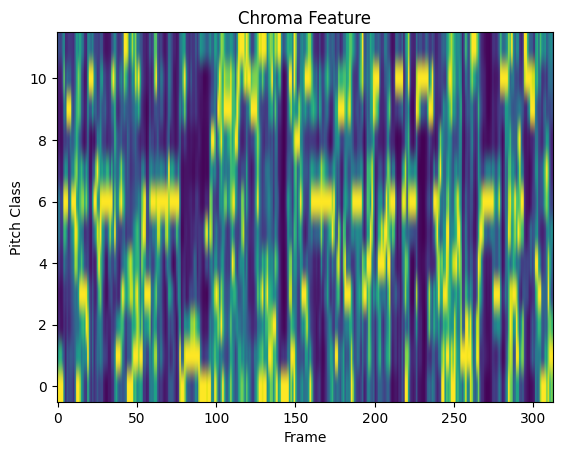

Type: <class 'tarfile.ExFileObject'>
File: <ExFileObject name=''>
File name: datashare/data_aug2/BXo1Tr_oJds_6.wav
Extracted file: <ExFileObject name=''> 

-----METADATA-----
Audio length: 160000 samples, Sample Rate: 16000
<class 'numpy.ndarray'> (160000,)
audio_data element: 0.05041504


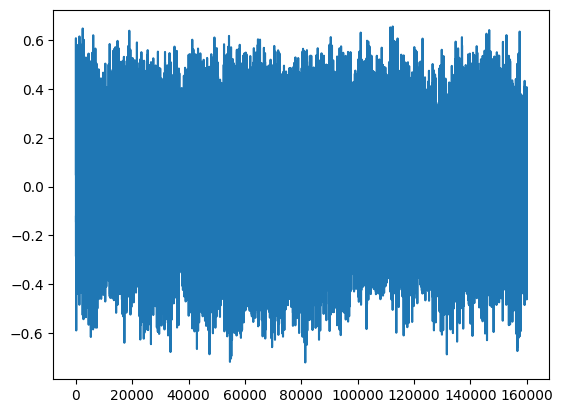

MFCCs: (13, 313)


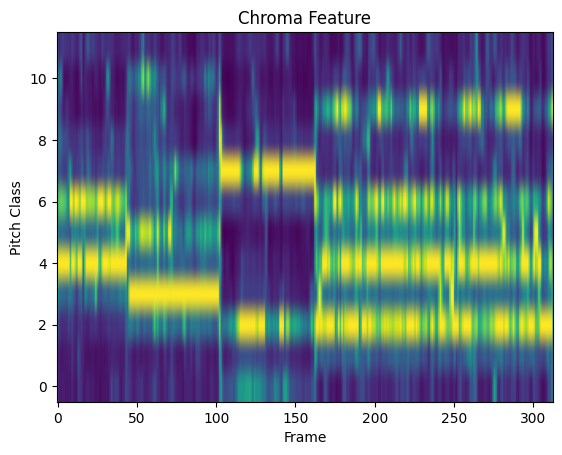

Type: <class 'tarfile.ExFileObject'>
File: <ExFileObject name=''>
File name: datashare/data_aug2/D2w3qHmJrdU_1.wav
Extracted file: <ExFileObject name=''> 

-----METADATA-----
Audio length: 160000 samples, Sample Rate: 16000
<class 'numpy.ndarray'> (160000,)
audio_data element: 0.0


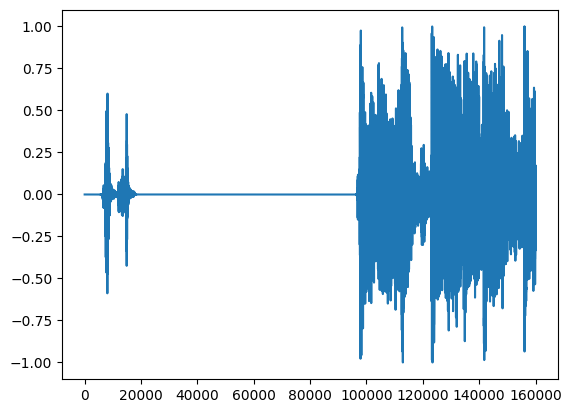

MFCCs: (13, 313)


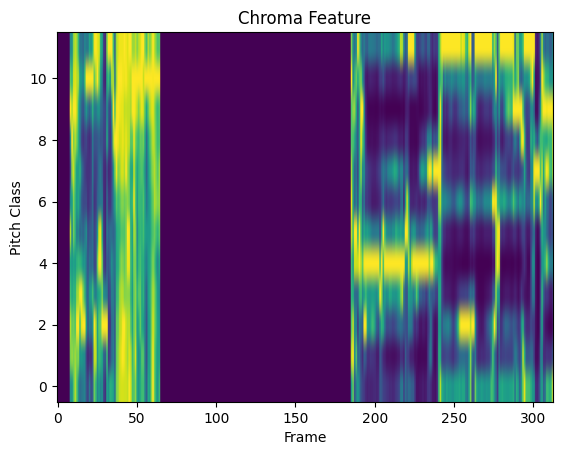

Type: <class 'tarfile.ExFileObject'>
File: <ExFileObject name=''>
File name: datashare/data_aug2/JIoA1KsfioQ_9.wav
Extracted file: <ExFileObject name=''> 

-----METADATA-----
Audio length: 160000 samples, Sample Rate: 16000
<class 'numpy.ndarray'> (160000,)
audio_data element: -0.1635437


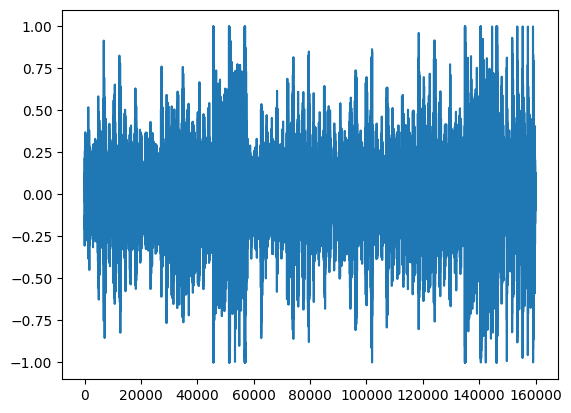

MFCCs: (13, 313)


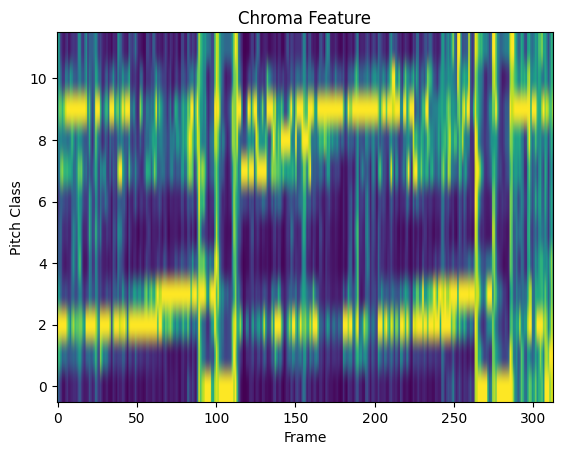

Type: <class 'tarfile.ExFileObject'>
File: <ExFileObject name=''>
File name: datashare/data_aug2/DP2vmsftZHY_8.wav
Extracted file: <ExFileObject name=''> 

-----METADATA-----
Audio length: 160000 samples, Sample Rate: 16000
<class 'numpy.ndarray'> (160000,)
audio_data element: 0.11904907


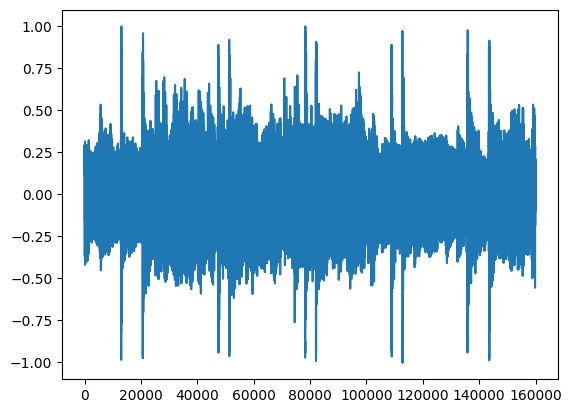

MFCCs: (13, 313)


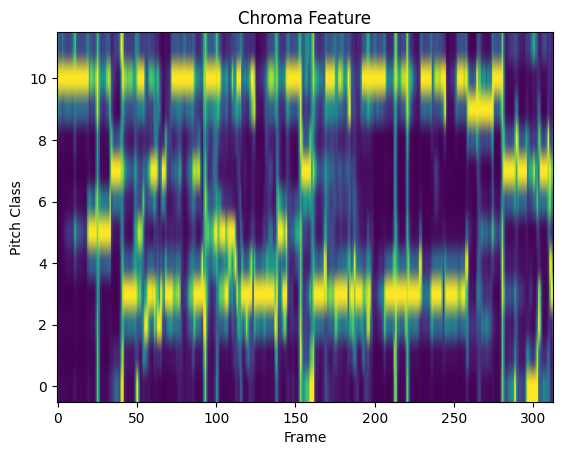

Type: <class 'tarfile.ExFileObject'>
File: <ExFileObject name=''>
File name: datashare/data_aug2/RdKQGIzKZ_c_3.wav
Extracted file: <ExFileObject name=''> 

-----METADATA-----
Audio length: 160000 samples, Sample Rate: 16000
<class 'numpy.ndarray'> (160000,)
audio_data element: -0.020996094


MFCCs: (13, 313)


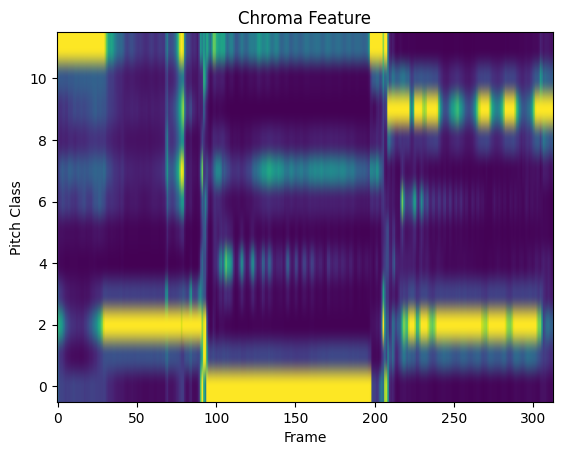

Type: <class 'tarfile.ExFileObject'>
File: <ExFileObject name=''>
File name: datashare/data_aug2/OiNlYrlJE4g_10.wav
Extracted file: <ExFileObject name=''> 

-----METADATA-----
Audio length: 160000 samples, Sample Rate: 16000
<class 'numpy.ndarray'> (160000,)
audio_data element: -0.039093018


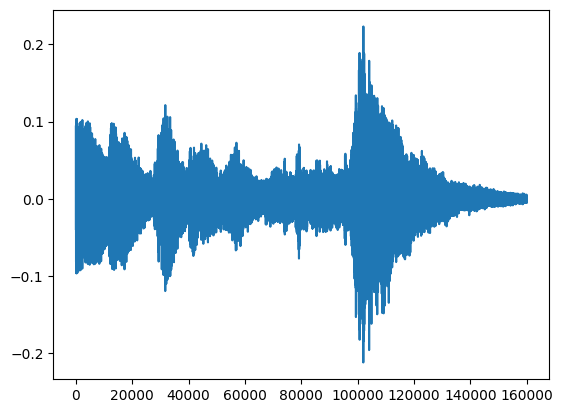

MFCCs: (13, 313)


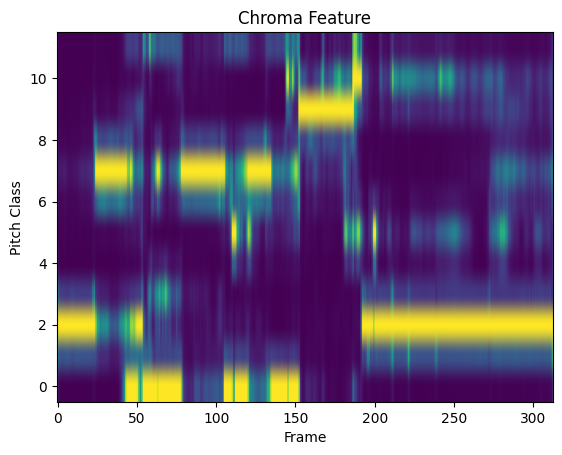

Type: <class 'tarfile.ExFileObject'>
File: <ExFileObject name=''>
File name: datashare/data_aug2/1FnT0RrfMEA_2.wav
Extracted file: <ExFileObject name=''> 

-----METADATA-----
Audio length: 160000 samples, Sample Rate: 16000
<class 'numpy.ndarray'> (160000,)
audio_data element: 0.0154418945


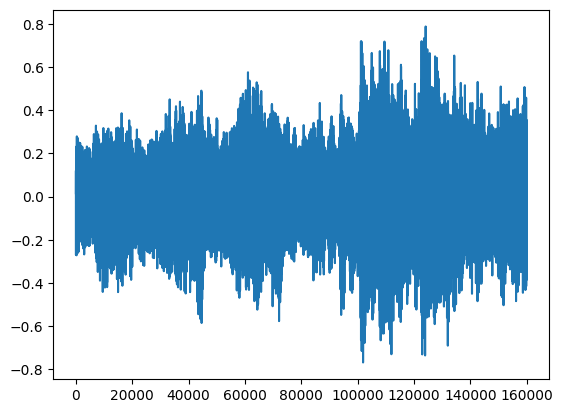

MFCCs: (13, 313)


Type: <class 'tarfile.ExFileObject'>
File: <ExFileObject name=''>
File name: datashare/data_aug2/G6A9NKeK8ko_2.wav
Extracted file: <ExFileObject name=''> 

-----METADATA-----
Audio length: 134003 samples, Sample Rate: 16000
<class 'numpy.ndarray'> (134003,)
audio_data element: -0.018218994


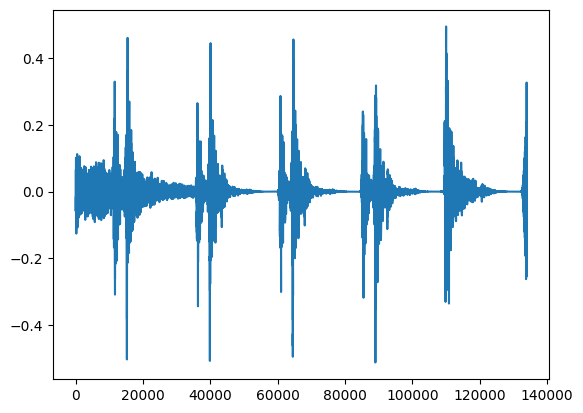

MFCCs: (13, 262)


Type: <class 'tarfile.ExFileObject'>
File: <ExFileObject name=''>
File name: datashare/data_aug2/wxKtBDKasgM_1.wav
Extracted file: <ExFileObject name=''> 

-----METADATA-----
Audio length: 140246 samples, Sample Rate: 16000
<class 'numpy.ndarray'> (140246,)
audio_data element: 0.058380127


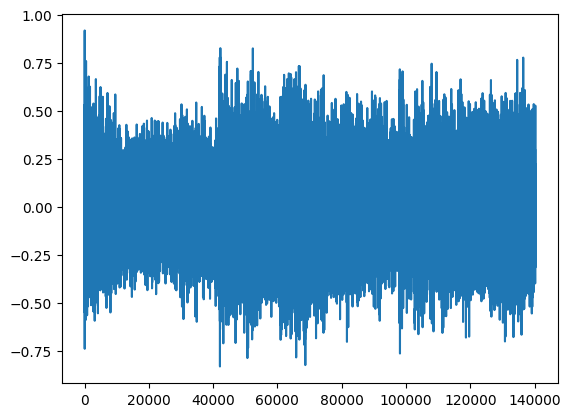

MFCCs: (13, 274)


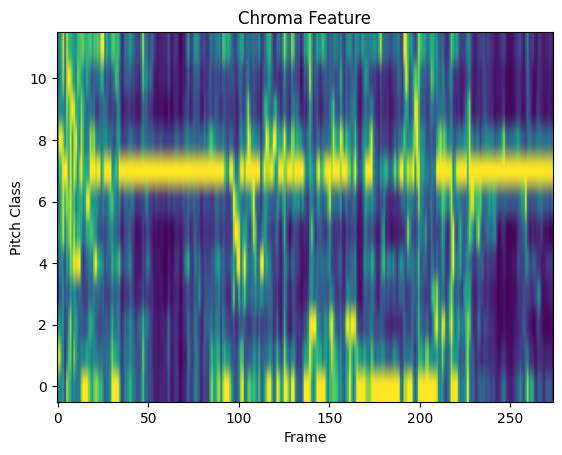

Type: <class 'tarfile.ExFileObject'>
File: <ExFileObject name=''>
File name: datashare/data_aug2/sfmAeijj5cM_8.wav
Extracted file: <ExFileObject name=''> 

-----METADATA-----
Audio length: 160000 samples, Sample Rate: 16000
<class 'numpy.ndarray'> (160000,)
audio_data element: 0.042236328


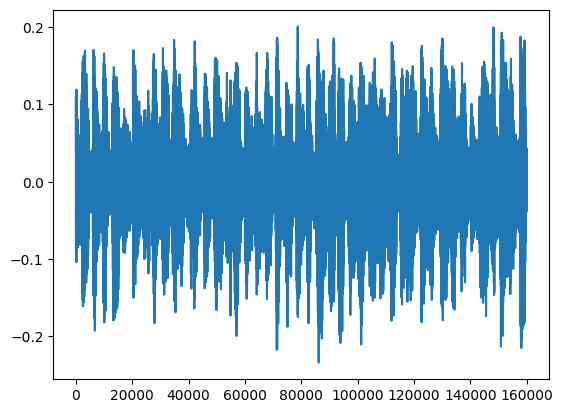

MFCCs: (13, 313)


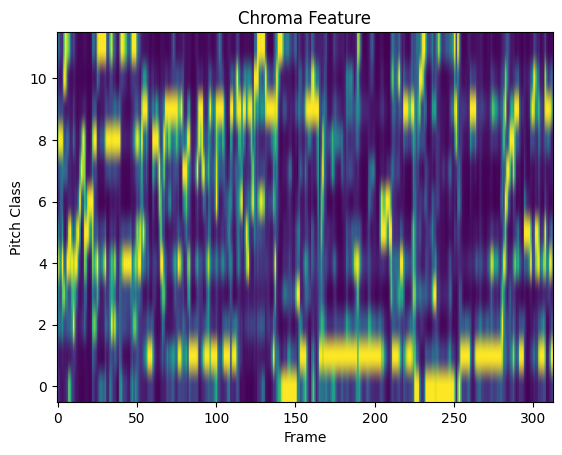

Type: <class 'tarfile.ExFileObject'>
File: <ExFileObject name=''>
File name: datashare/data_aug2/cFIZraIPAXE_4.wav
Extracted file: <ExFileObject name=''> 

-----METADATA-----
Audio length: 144602 samples, Sample Rate: 16000
<class 'numpy.ndarray'> (144602,)
audio_data element: 0.15716553


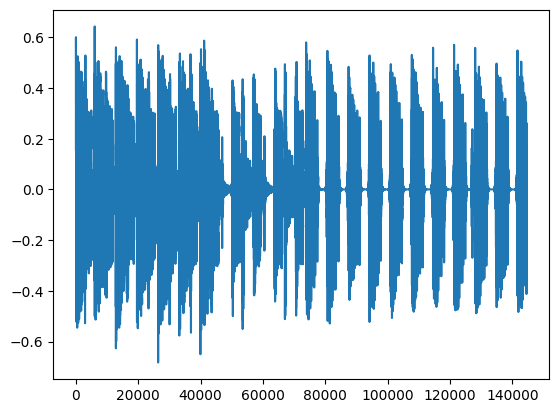

MFCCs: (13, 283)


KeyboardInterrupt: 

In [36]:
# get all audio files
open_audio_file()